<a href="https://colab.research.google.com/github/pfun/makeyourownneuralnetwork/blob/master/Copy_of_Hyperparameter_Optimization_Fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up The Model

Before we get started with hyperparameter optimization, we need a model to optimize. Here, we'll be training a DenseNet201 on the CIFAR10 dataset.

You won't get state of the art results, but that's intentional. We're not trying to create the best possible model, we're only going to evaluate different hyperparameter optimization schemes.


In [ ]:
%matplotlib inline

First, let's import the fastai library, a high level wrapper for PyTorch (similar to Keras for Tensorflow).

This will help us quickly build a descent model so that we can focus on hyperparameter optimization.

In [ ]:
import fastai
from fastai.vision import *

Now, we'll get a dataset and set up some basic data augmentation (which will be used later).

Here's we're using a small subset of the MNIST dataset, so that the model trains really quickly and so that you get to see results in real time.

But if you want to take it up a notch, replace `path = untar_data(URLs.MNIST_SAMPLE)` with `path = untar_data(URLs.CIFAR)`.

You'll also want to increase the number of epochs to at least 3.

In [ ]:
# Download the dataset
path = untar_data(URLs.MNIST_SAMPLE)

# Uncomment this line to use the CIFAR10 datast instead of MNIST
# path = untar_data(URLs.CIFAR)

# Set up the training and validation datasets
data = ImageDataBunch.from_folder(path, bs = 512).normalize()

To make our life easier as we start to evaluate different hyperparameter optimization schemes, we'll define a `fit_with()` function that trains our model with certain hyperparameters.

In [ ]:
# lr = learning rate
# wd = weight decay
# dp = dropout probability

def fit_with(lr,wd,dp):
    
    # Create the model using a specified dropout and weight decay
    learn = cnn_learner(data, models.resnet18, metrics=accuracy, ps=dp)
    
    
    # Train the model for a specified number of epochs using a specified max learning rate
    learn.fit_one_cycle(1, max_lr=lr)
    
    # Plot the loss over time
    learn.recorder.plot_losses()
    
    # Save, print, and return the model's accuracy
    acc = float(learn.validate(learn.data.valid_dl)[1])
    
    print("Current Accuracy:" + str(acc*100))
    
    return acc, learn
    

Let's quickly train a basic model using random hyperparameters

Accuracy:46.22178673744202


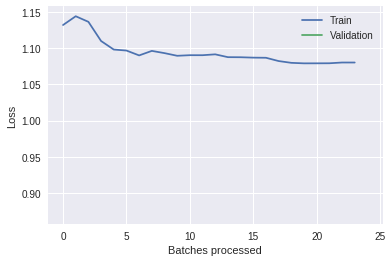

In [ ]:
init_acc, init_model = fit_with(lr=1e-6, wd=0.4, dp=0.7)
init_model.save('/home/init_model')

Hmmm...

That didn't turn out so great. Let's see if we can get something better by tuning the hyperparameters.

# Grid Search

For our first hyperparameter optimization algorithm, let's try grid search. Refer back to the [main article](https://blog.nanonets.com/hyp-opt) if you forgot how it works. Essentially, it's brute force.

To execute Grid search, we need to first create a set of possible hyperparameter values.

In [ ]:
lrs = [1e-2, 1e-3, 1e-4]
wds = [1e-1, 1e-2, 1e-3]
dps = [0.1, 0.3, 0.5]

Then we just loop over all the possible values, and save the model when the accuracy is the highest.


In practice, grid search is usually paralellized, which each training run occuring on a different machine. However, the following code block uses `for` loops for simplicity and to run  in a simple notebook.

**WARNING:** This code block can take an *extremely* long time to execute, so it is reccomended that you simply view the code.


Accuracy:61.82531714439392
The highest accuracy is: 99.36211705207825


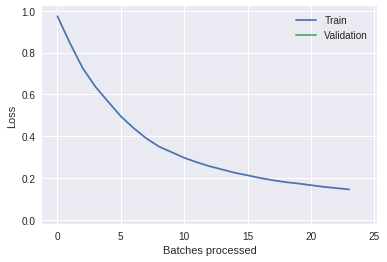

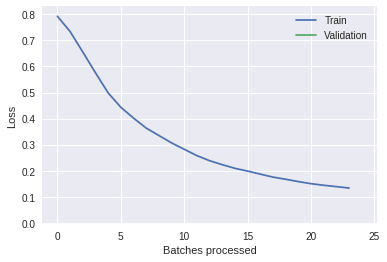

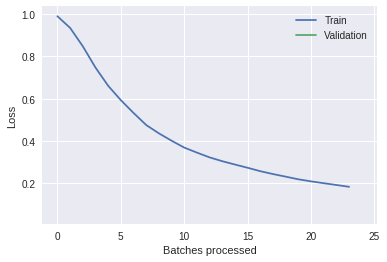

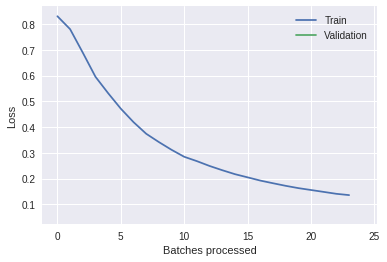

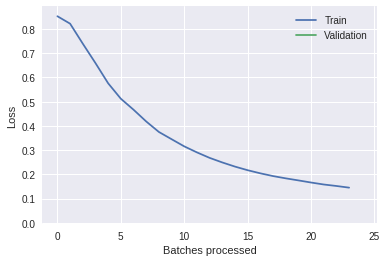

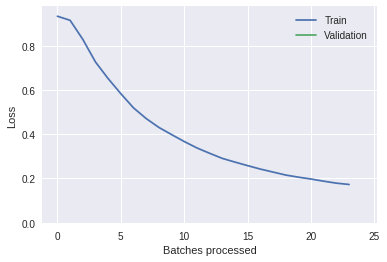

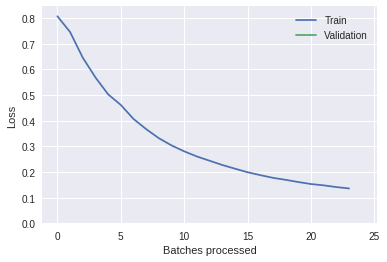

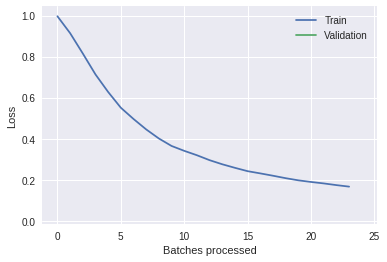

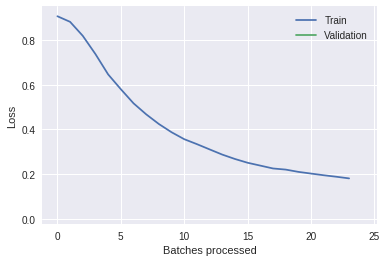

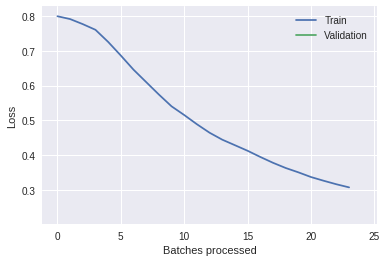

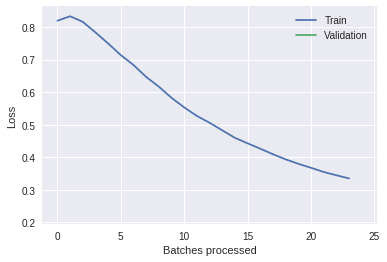

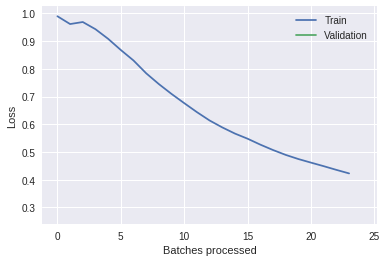

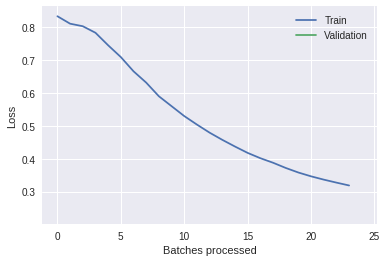

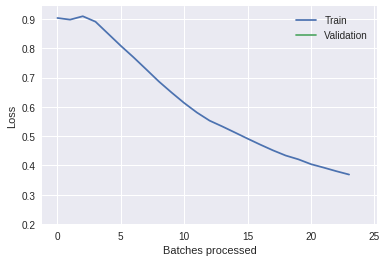

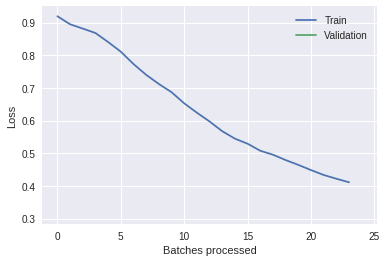

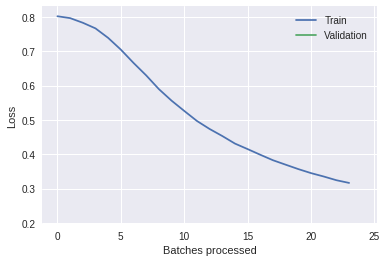

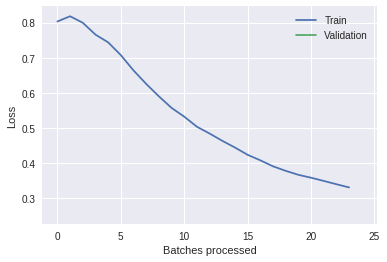

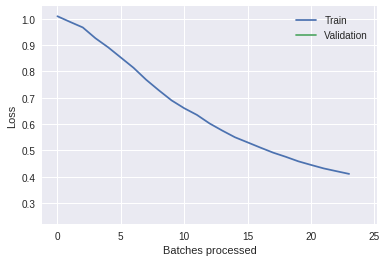

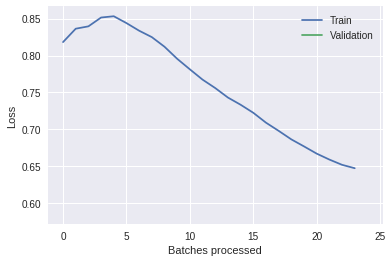

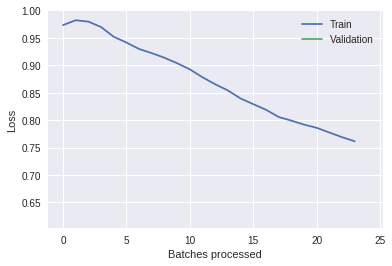

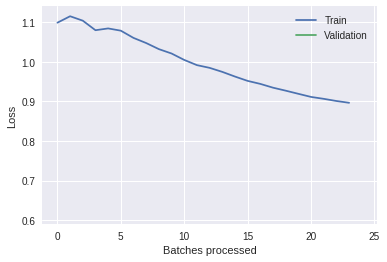

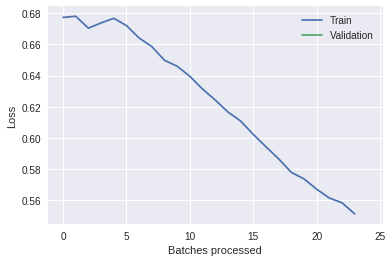

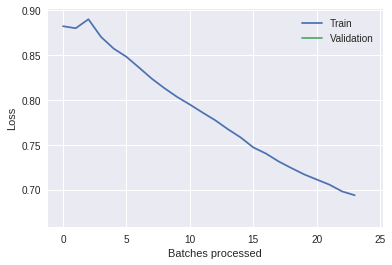

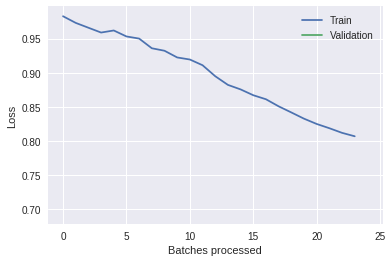

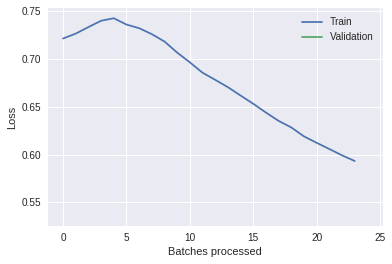

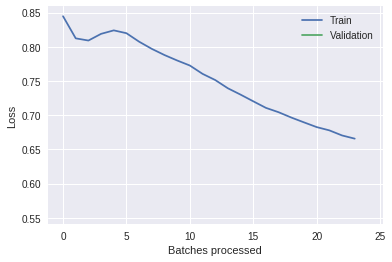

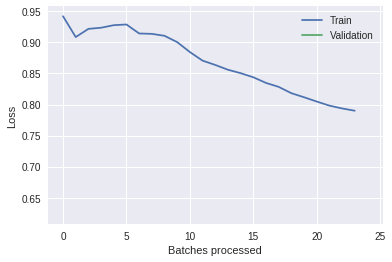

In [ ]:
max_acc = 0

for lr in lrs:
  for wd in wds:
    for dp in dps:
      
      current_accuracy, model = fit_with(lr,wd,dp)
                
      if (current_accuracy > max_acc):
        model.save('/home/grid_search_best_model')
        max_acc = current_accuracy
        
        
print("The highest accuracy is: " + str(max_acc*100))

# Random Search

Random search is almost same as grid search, except we change the set of values that we loop over. Instead of a hard-coded set of values, we sample hyperparameters from a distribution i.e. choose them at random.

In [ ]:
import random

max_acc = 0
# The number of different hyperparameter values to try
num_iters = 10

The second step is the same as that in grid search. Just try out the values and see what works best.

**WARNING:** This code block can take an *extremely* long time to execute, so it is reccomended that you simply view the code.

Accuracy:50.0490665435791
The highest accuracy is: 66.87929630279541


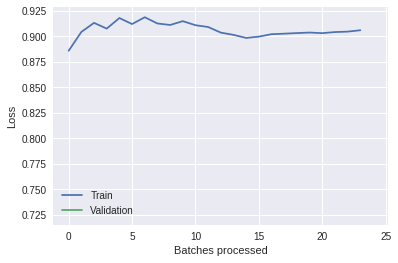

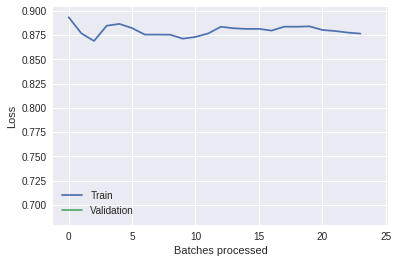

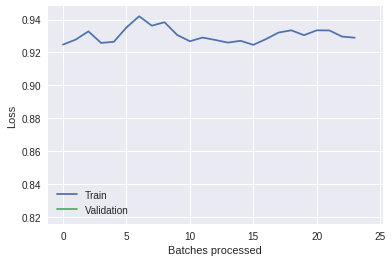

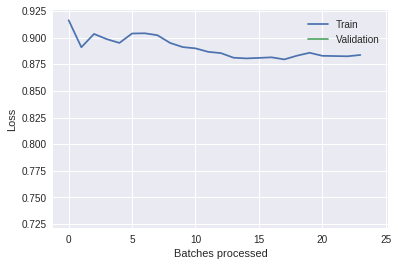

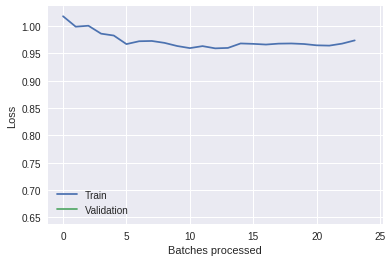

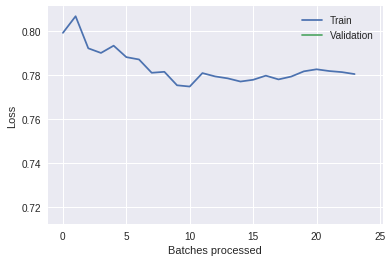

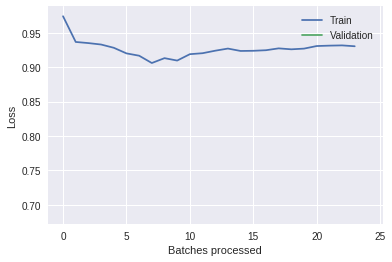

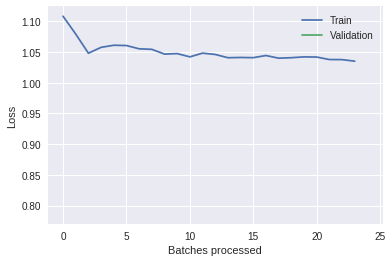

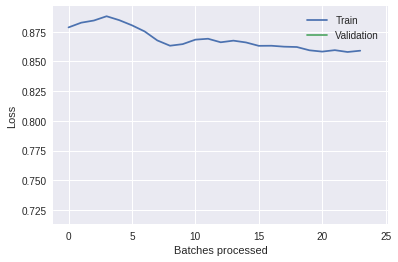

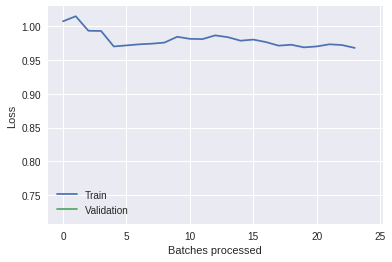

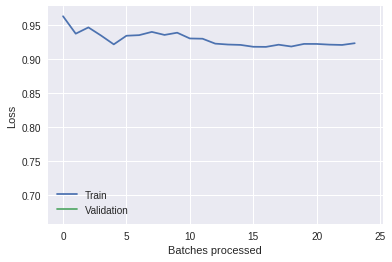

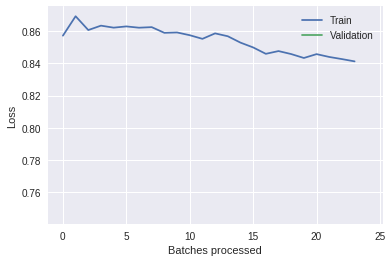

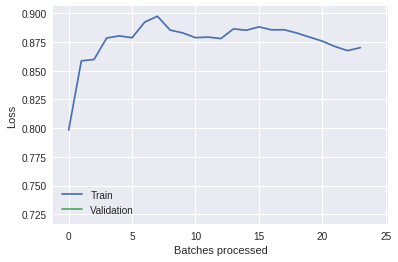

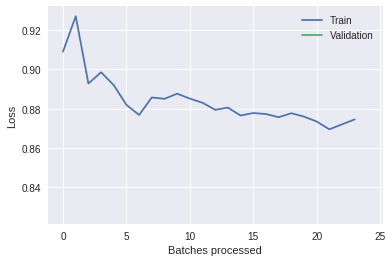

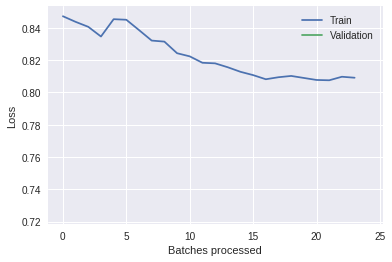

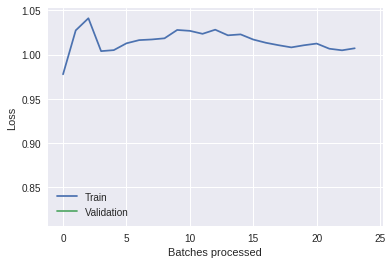

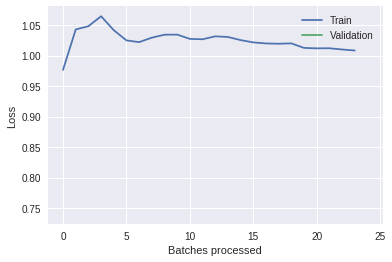

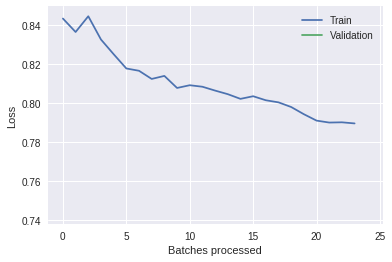

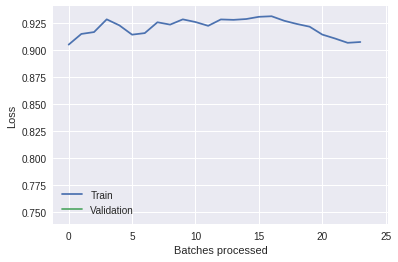

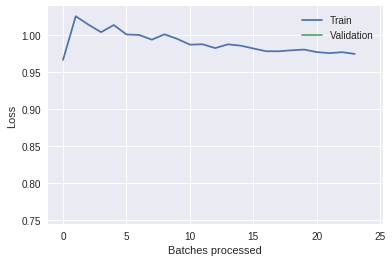

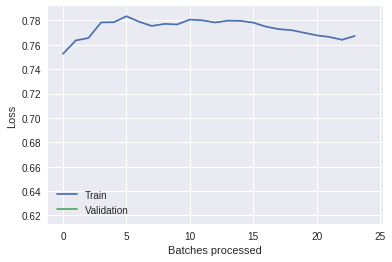

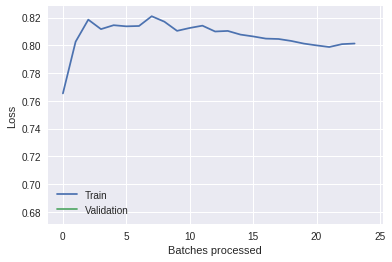

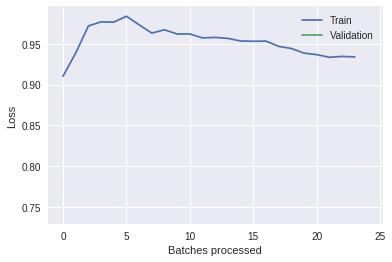

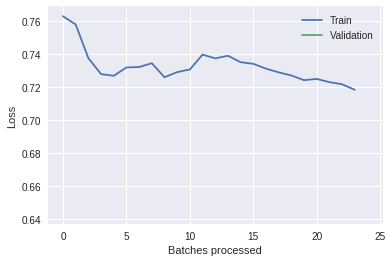

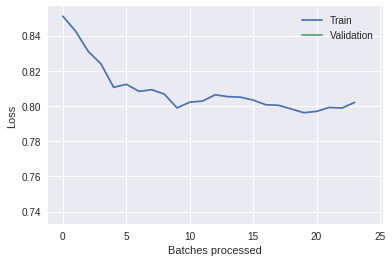

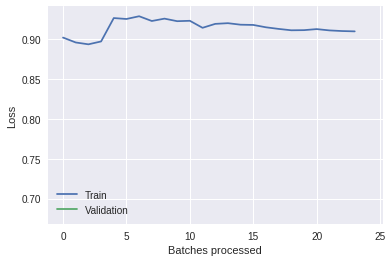

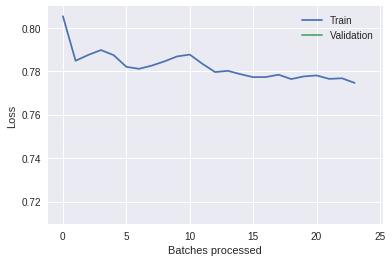

In [ ]:
for iteration in range(num_iters):
  
  # Pick random hyperparameters in a specified range
  lr = 10**(-random.randint(3,7))
  wd = 10**(-random.randint(3,7))
  dp = random.uniform(0.1,0.5)
  
  current_accuracy, model = fit_with(lr,wd,dp)
  
  if (current_accuracy > max_acc):
    model.save('/home/grid_search_best_model')
    max_acc = current_accuracy
        
        
print("The highest accuracy is: " + str(max_acc*100))

# Baysian Optimization

This the moment you've all been waiting for.

To implement Baysian optimization with a Gaussian process (explained in the [main article](https://blog.nanonets.com/hyp-opt)), we're going to use the `bayesian-optimization` [ package](https://github.com/fmfn/BayesianOptimization)

In [ ]:
!pip install bayesian-optimization

Luckily, we already have a function to optimize: `fit_with()`!

There's only one problem, the function won't work in it's current form with `baysian-optimization`.

So we'll make one small change:  we're only going to return the accuracy, not the `learn` object.


In [ ]:
def fit_with(lr,wd,dp):
    
    # Create the model using a specified dropout and weight decay
    learn = cnn_learner(data, models.resnet18, metrics=accuracy, ps=dp)
    
    
    # Train the model for a specified number of epochs using a specified max learning rate
    learn.fit_one_cycle(1, max_lr=lr)
    
    # Plot the loss over time
    learn.recorder.plot_losses()
    
    # Save, print, and return the model's accuracy
    acc = float(learn.validate(learn.data.valid_dl)[1])
    
    print("Accuracy:" + str(acc*100))
    
    # The small change: we're only going to return the accuracy
    
    return acc

Next, we define our Bayesian optimizer using the rules set by the `baysian-optimization` library, and let it do it's magic.

**Note :** This step may also take a very long time (a few hours) to complete, but considerably less than random search and grid search.

Accuracy:59.273797273635864
|  4        |  0.5927   |  0.5      |  0.0001   |  0.0001   |
Iteration 0: 
	{'target': 0.9911677837371826, 'params': {'dp': 0.2668088018810296, 'lr': 0.007231212485077366, 'wd': 0.00014573848945622018}}
Iteration 1: 
	{'target': 0.9425907731056213, 'params': {'dp': 0.22093302905273593, 'lr': 0.0015528833190894193, 'wd': 0.037026204048042244}}
Iteration 2: 
	{'target': 0.9926398396492004, 'params': {'dp': 0.5, 'lr': 0.01, 'wd': 0.4}}
Iteration 3: 
	{'target': 0.5927379727363586, 'params': {'dp': 0.5, 'lr': 0.0001, 'wd': 0.0001}}
{'target': 0.9926398396492004, 'params': {'dp': 0.5, 'lr': 0.01, 'wd': 0.4}}


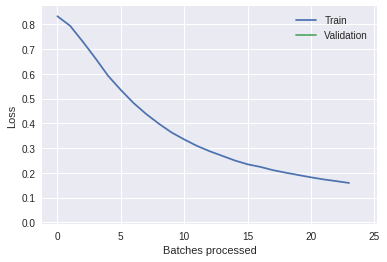

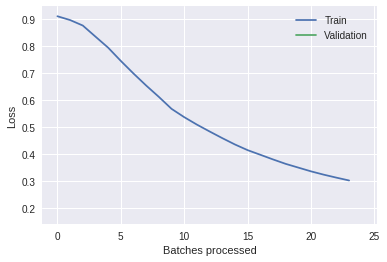

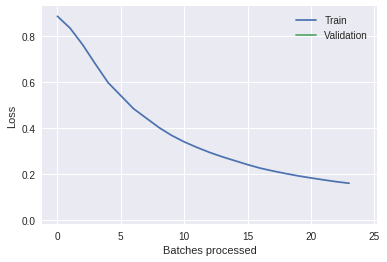

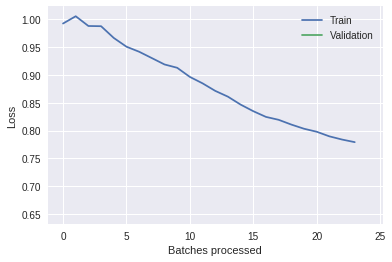

In [ ]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'lr': (1e-4, 1e-2), 'wd':(1e-4,0.4), 'dp':(0.1,0.5)}

optimizer = BayesianOptimization(
    f=fit_with,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(init_points=2, n_iter=2,)



for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(optimizer.max)

If you scroll all the way to the bottom, you'll see the result of Bayesian optimization at each timestep, as well as a dictionary with the best hyperparameter settings.

Look at the accuracy! We got to 98% + in just 4 iterations!

# Conclusion

And ... 

That's it for today, folks. If you haven't already, go on and check out the [main article](https://blog.nanonets.com/hyp-opt) that this notebook is based on.

If you   `shift + enter` ed your way to the bottom, shame on you. Go back up to the top and actually think about what you're running.

Come on, go up now...

## A Quick Note On Accuracy

The results you obtained here are not representative of real world data. The MNIST datset was used for simplicity.

If you want a more accurate comparison of these hyperparameter optimization methods, you can run the notebook top to bottom with the CIFAR10 dataset instead (only requires changing one line, and waiting much longer).

In practice, Bayesian optimization will give the best results, followed by random search and then grid search.

## For The More Sophisticated Deep Learning Practitioner

If you're interested, there's also a version of this notebook written in pure [pytorch](https://colab.research.google.com/gist/iyaja/f9fc63ef65b6cc74409dc635c2d80861/hyperparameter-optimization-pytorch.ipynb).  This might give you a better understanding of the behind-the-scenes training process. Check it out [here](https://colab.research.google.com/gist/iyaja/f9fc63ef65b6cc74409dc635c2d80861/hyperparameter-optimization-pytorch.ipynb).


If the link above didn't work, paste the following in your browser:


https://colab.research.google.com/gist/iyaja/f9fc63ef65b6cc74409dc635c2d80861/hyperparameter-optimization-pytorch.ipynb